In [1]:
!pip install category_encoders

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import category_encoders as ce


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import os
import re
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.2 MB/s eta 0:00:00


In [2]:
# Load the data
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')


In [3]:
# Feature Engineering
def extract_engine_power(engine_str):
    match = re.search(r'(\d+(\.\d+)?)HP', engine_str)
    if match:
        return float(match.group(1))
    return 0

train_df['engine_power'] = train_df['engine'].apply(extract_engine_power)
test_df['engine_power'] = test_df['engine'].apply(extract_engine_power)

# Drop the original engine column
train_df.drop(columns=['engine'], inplace=True)
test_df.drop(columns=['engine'], inplace=True)

# Add age of the car
train_df['age'] = 2024 - train_df['model_year']
test_df['age'] = 2024 - test_df['model_year']


In [4]:
# Remove outliers based on the price column
q1 = train_df['price'].quantile(0.25)
q3 = train_df['price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
train_df = train_df[(train_df['price'] >= lower_bound) & (train_df['price'] <= upper_bound)]


In [5]:
# Separate the target column from the training set
y = train_df['price']
X_train_full = train_df.drop(columns=['price'])


In [6]:
# Encoding categorical variables
categorical_features = ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
encoder = ce.OneHotEncoder(cols=categorical_features, handle_unknown='ignore', use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train_full)
X_test_encoded = encoder.transform(test_df)


In [7]:
# Ensure the test set has the same columns as the train set
train_columns = set(X_train_encoded.columns)
test_columns = set(X_test_encoded.columns)

missing_train_cols = test_columns - train_columns
missing_test_cols = train_columns - test_columns

for col in missing_train_cols:
    X_train_encoded[col] = 0
for col in missing_test_cols:
    X_test_encoded[col] = 0


In [8]:
# Reorder columns to match
X_test_encoded = X_test_encoded[X_train_encoded.columns]


In [9]:
# Standardize numerical features
numerical_features = ['model_year', 'milage', 'engine_power', 'age']
scaler = StandardScaler()
X_train_encoded[numerical_features] = scaler.fit_transform(X_train_encoded[numerical_features])
X_test_encoded[numerical_features] = scaler.transform(X_test_encoded[numerical_features])


In [10]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_train_encoded, y, test_size=0.2, random_state=42)


In [11]:
# Build the model
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Linear activation for regression
])

In [12]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])


In [13]:
# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])


Epoch 1/100
1280/1280 [==============================] - 11s 8ms/step - loss: 612196096.0000 - mse: 612196096.0000 - val_loss: 590203200.0000 - val_mse: 590203200.0000
Epoch 2/100
1280/1280 [==============================] - 10s 8ms/step - loss: 597836992.0000 - mse: 597836992.0000 - val_loss: 577905600.0000 - val_mse: 577905600.0000
Epoch 3/100
1280/1280 [==============================] - 9s 7ms/step - loss: 431757088.0000 - mse: 431757088.0000 - val_loss: 184785488.0000 - val_mse: 184785488.0000
Epoch 4/100
1280/1280 [==============================] - 8s 7ms/step - loss: 196411760.0000 - mse: 196411760.0000 - val_loss: 187608848.0000 - val_mse: 187608848.0000
Epoch 5/100
1280/1280 [==============================] - 10s 8ms/step - loss: 189191072.0000 - mse: 189191072.0000 - val_loss: 164346528.0000 - val_mse: 164346528.0000
Epoch 6/100
1280/1280 [==============================] - 9s 7ms/step - loss: 187749232.0000 - mse: 187749232.0000 - val_loss: 158079392.0000 - val_mse: 158079392.

In [14]:
# Evaluate the model
val_predictions = model.predict(X_val)
mse = mean_squared_error(y_val, val_predictions)
r2 = r2_score(y_val, val_predictions)

print(f'MSE: {mse}')
print(f'R2 Score: {r2}')


320/320 [==============================] - 1s 3ms/step
MSE: 133724943.09138523
R2 Score: 0.63500573146121


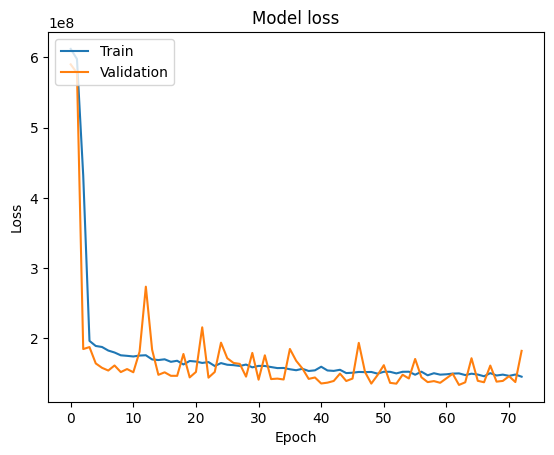

In [15]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
# Make predictions on the test set
test_predictions = model.predict(X_test_encoded)

1131/1131 [==============================] - 3s 2ms/step


In [17]:
# Create a DataFrame for the results
submission_df = pd.DataFrame({'id': test_df['id'], 'price': test_predictions.flatten()})

In [19]:
# Save predictions to a CSV file in the required format
submission_df.to_csv('Test_Predictions_Keras_Improved.csv', index=False)